In [25]:
import  pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




In [2]:
import sys
import os

# Add scripts path
sys.path.append(os.path.abspath('../scripts'))

In [3]:
from load_data import connect_to_db


In [4]:
query = "SELECT * FROM xdr_data;"
df = connect_to_db(query)
if df is not None:
    print("successfuly connected")
else:
    print("failed to connect")

Database connected successfully!


/home/gabie/Telecom-User-Analysis/scripts/load_data.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query,conn)


successfuly connected


In [5]:
df

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,2.780823e+08,1.434415e+07,1.717444e+08,8.814393e+06,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,6.087501e+08,1.170709e+06,5.269042e+08,1.505514e+07,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,2.295846e+08,3.956300e+05,4.106926e+08,4.215763e+06,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,7.995382e+08,1.084972e+07,7.490399e+08,1.279728e+07,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,5.277072e+08,3.529801e+06,5.507095e+08,1.391032e+07,38542814.0,569138589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0


In [16]:
top_handsets = df['Handset Type'].value_counts().head(10)
print("Top 10 Handsets:\n", top_handsets)


Top 10 Handsets:
 Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64


In [10]:
top_manufacturers = df['Handset Manufacturer'].value_counts().head(3)
print("Top 3 Handset Manufacturers:\n", top_manufacturers)


Top 3 Handset Manufacturers:
 Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64


In [12]:
for manufacturer in top_manufacturers.index:
    top_handsets_per_manufacturer = df[df['Handset Manufacturer'] == manufacturer]['Handset Type'].value_counts().head(5)
    print(f"Top 5 Handsets for {manufacturer}:\n", top_handsets_per_manufacturer)


Top 5 Handsets for Apple:
 Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64
Top 5 Handsets for Samsung:
 Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galaxy J5 (Sm-J530)     3696
Samsung Galaxy J3 (Sm-J330)     3484
Samsung Galaxy S7 (Sm-G930X)    3199
Name: count, dtype: int64
Top 5 Handsets for Huawei:
 Handset Type
Huawei B528S-23A                  19752
Huawei E5180                       2079
Huawei P20 Lite Huawei Nova 3E     2021
Huawei P20                         1480
Huawei Y6 2018                      997
Name: count, dtype: int64


In [22]:
# Analyze User Behavior on Applications Analyze User Behavior on Applications
user_behavior = df.groupby('IMSI').agg({
    'Bearer Id': 'sum',
    'Dur. (ms)': 'sum',
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum',
})
user_behavior['total_data'] = user_behavior['Total DL (Bytes)'] + user_behavior['Total UL (Bytes)']
print(user_behavior.head())


                 Bearer Id  Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  \
IMSI                                                                        
2.040471e+14  7.277826e+18   869844.0        78697597.0        60456049.0   
2.040808e+14  7.277826e+18   877385.0       194828056.0        37295915.0   
2.082001e+14  6.917538e+18    86019.0        31376981.0        53794658.0   
2.082001e+14  6.917538e+18    86254.0       392918313.0        33583272.0   
2.082001e+14  2.622897e+19   573923.0       961767023.0        71325004.0   

                total_data  
IMSI                        
2.040471e+14  1.391536e+08  
2.040808e+14  2.321240e+08  
2.082001e+14  8.517164e+07  
2.082001e+14  4.265016e+08  
2.082001e+14  1.033092e+09  


In [27]:
# Check for missing values
print("Missing Values Summary:")
print(df.isnull().sum())

# Fill missing numeric columns with the mean
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(exclude=["number"]).columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")


Missing Values Summary:
Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < 

In [28]:
# Define a function to handle outliers using the IQR method
def handle_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(col, lower_bound, upper_bound)

# Apply outlier treatment for numeric columns
for col in numeric_cols:
    df[col] = handle_outliers(df[col])


In [29]:
# Summary of data types and unique values
variable_summary = pd.DataFrame({
    "Data Type": df.dtypes,
    "Unique Values": df.nunique()
})
print("Variable Summary:")
print(variable_summary)

# Save this summary to a CSV for presentation purposes
variable_summary.to_csv("variable_summary.csv", index=True)


Variable Summary:
                                         Data Type  Unique Values
Bearer Id                                  float64         134709
Start                                       object           9998
Start ms                                   float64           1001
End                                         object           6404
End ms                                     float64           1001
Dur. (ms)                                  float64          82603
IMSI                                       float64          97428
MSISDN/Number                              float64          90038
IMEI                                       float64         107271
Last Location Name                          object          45548
Avg RTT DL (ms)                            float64            222
Avg RTT UL (ms)                            float64             42
Avg Bearer TP DL (kbps)                    float64          30141
Avg Bearer TP UL (kbps)                    float64        

In [30]:
#Segment users into top five decile classes based on Dur. (ms) and compute total data for each decile.
df['total_data'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
df['duration_decile'] = pd.qcut(df['Dur. (ms)'], 5, labels=False)

# Compute total data per decile
decile_data = df.groupby('duration_decile')['total_data'].sum().reset_index()
print("Decile Data Summary:")
print(decile_data)


Decile Data Summary:
   duration_decile    total_data
0                0  1.488405e+13
1                1  2.361998e+13
2                2  6.089086e+12
3                3  1.485374e+13
4                4  1.491834e+13


In [31]:
basic_metrics = df.describe()
print("Basic Metrics Summary:")
print(basic_metrics)

# Save to CSV for reporting
basic_metrics.to_csv("basic_metrics.csv")


Basic Metrics Summary:
          Bearer Id       Start ms         End ms      Dur. (ms)  \
count  1.500010e+05  150001.000000  150001.000000  150001.000000   
mean   1.013887e+19     499.188200     498.800880   99572.128983   
std    2.883600e+18     288.610872     288.096693   59084.184127   
min    6.917538e+18       0.000000       0.000000    7142.000000   
25%    7.349883e+18     250.000000     251.000000   57442.000000   
50%    7.349883e+18     499.000000     500.000000   86399.000000   
75%    1.304243e+19     749.000000     750.000000  132430.000000   
max    1.318654e+19     999.000000     999.000000  244912.000000   

               IMSI  MSISDN/Number          IMEI  Avg RTT DL (ms)  \
count  1.500010e+05   1.500010e+05  1.500010e+05    150001.000000   
mean   2.082015e+14   3.366999e+10  4.847455e+13        72.862020   
std    3.925668e+08   3.532589e+07  2.237359e+13        51.361714   
min    2.082008e+14   3.360168e+10  4.400152e+11         0.000000   
25%    2.082014e+14

In [32]:
#Non-Graphical Univariate Analysis

dispersion_params = df[numeric_cols].agg(['mean', 'median', 'std', 'var', 'min', 'max'])
print("Dispersion Parameters:")
print(dispersion_params)

# Save to CSV for reporting
dispersion_params.to_csv("dispersion_params.csv")


Dispersion Parameters:
           Bearer Id      Start ms        End ms     Dur. (ms)          IMSI  \
mean    1.013887e+19    499.188200    498.800880  9.957213e+04  2.082015e+14   
median  7.349883e+18    499.000000    500.000000  8.639900e+04  2.082015e+14   
std     2.883600e+18    288.610872    288.096693  5.908418e+04  3.925668e+08   
var     8.315146e+36  83296.235554  82999.704445  3.490941e+09  1.541087e+17   
min     6.917538e+18      0.000000      0.000000  7.142000e+03  2.082008e+14   
max     1.318654e+19    999.000000    999.000000  2.449120e+05  2.082023e+14   

        MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
mean     3.366999e+10  4.847455e+13        72.862020        12.037797   
median   3.366380e+10  3.572241e+13        54.000000         7.000000   
std      3.532589e+07  2.237359e+13        51.361714        11.040917   
var      1.247919e+15  5.005776e+26      2638.025639       121.901858   
min      3.360168e+10  4.400152e+11         0.00000

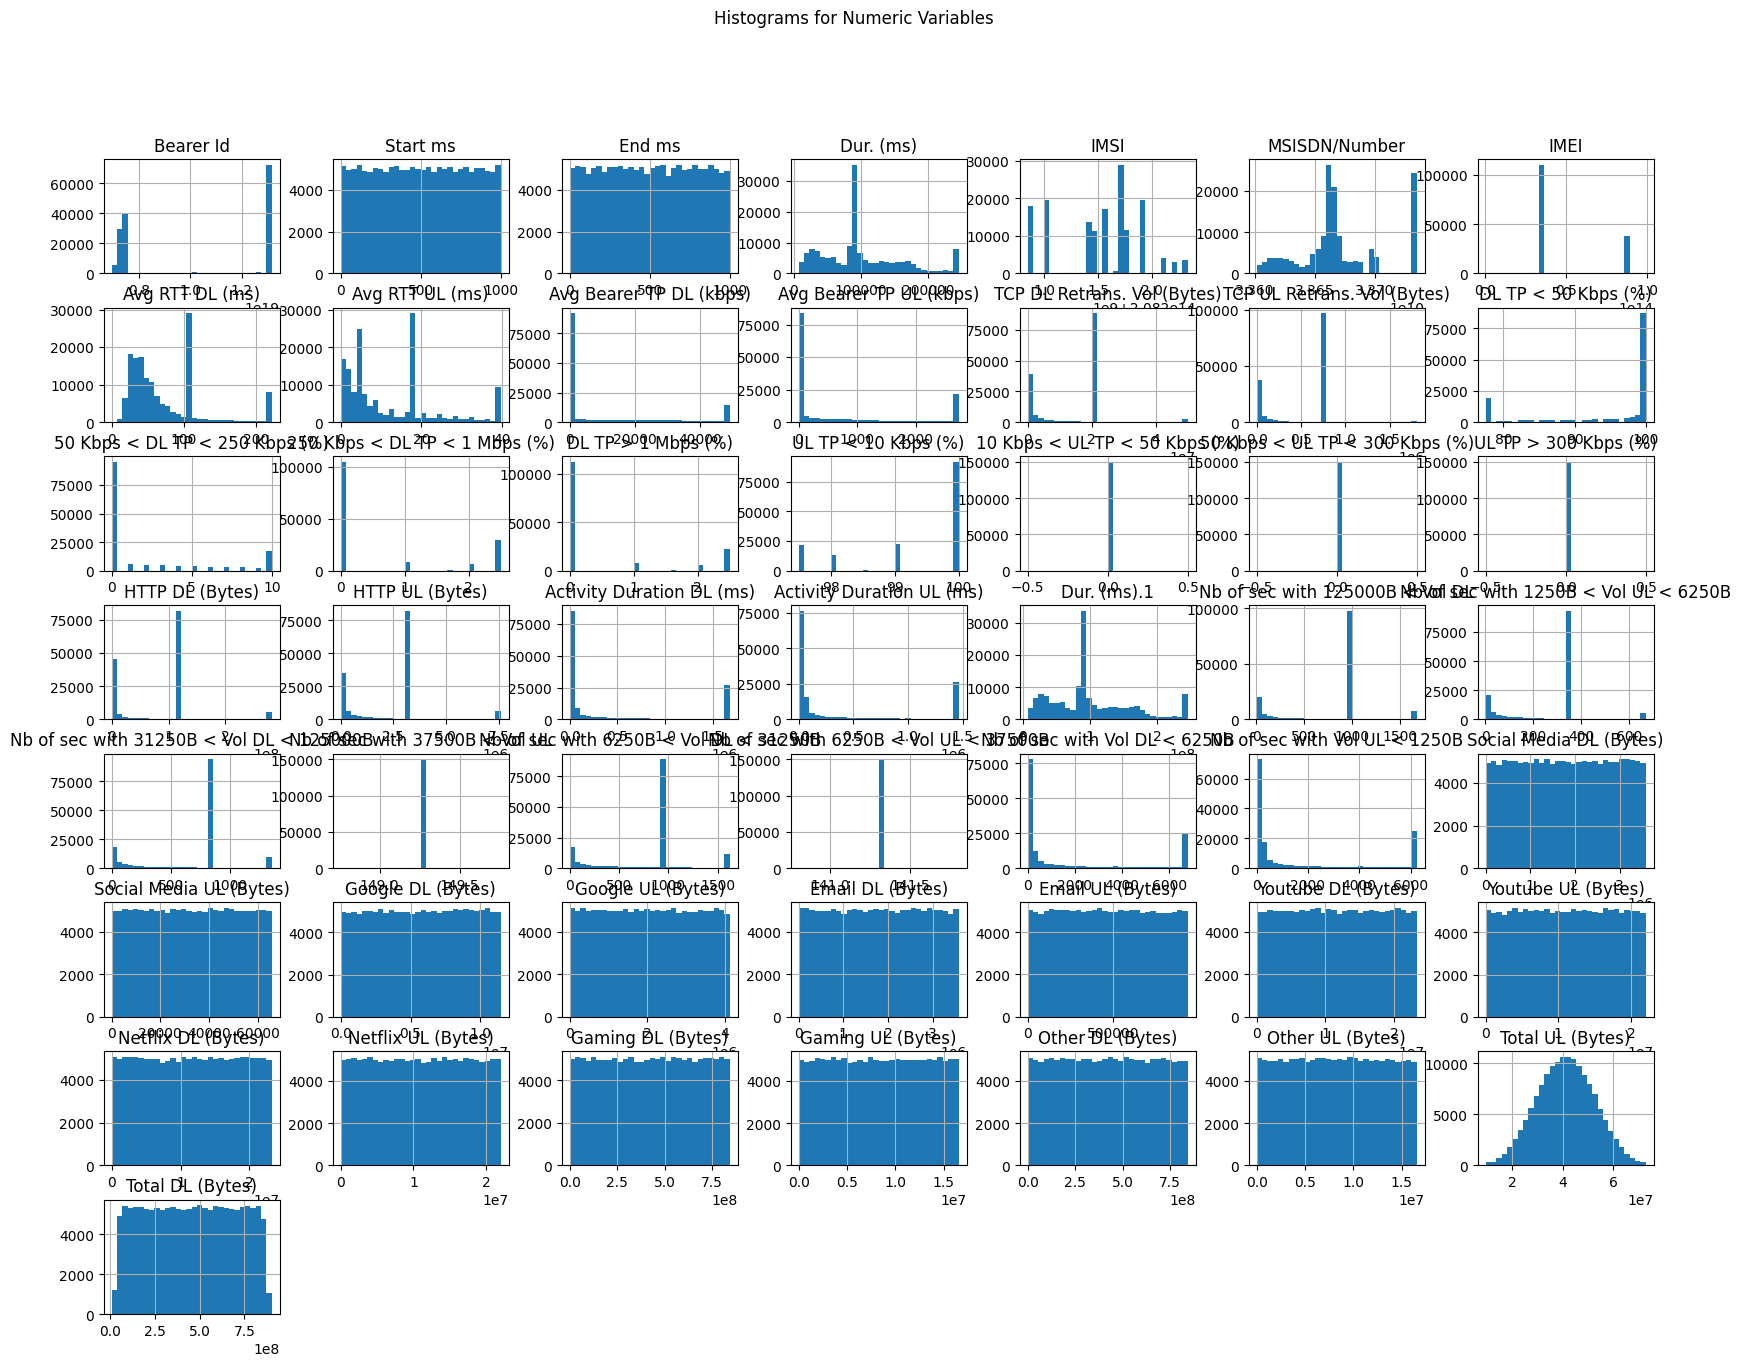

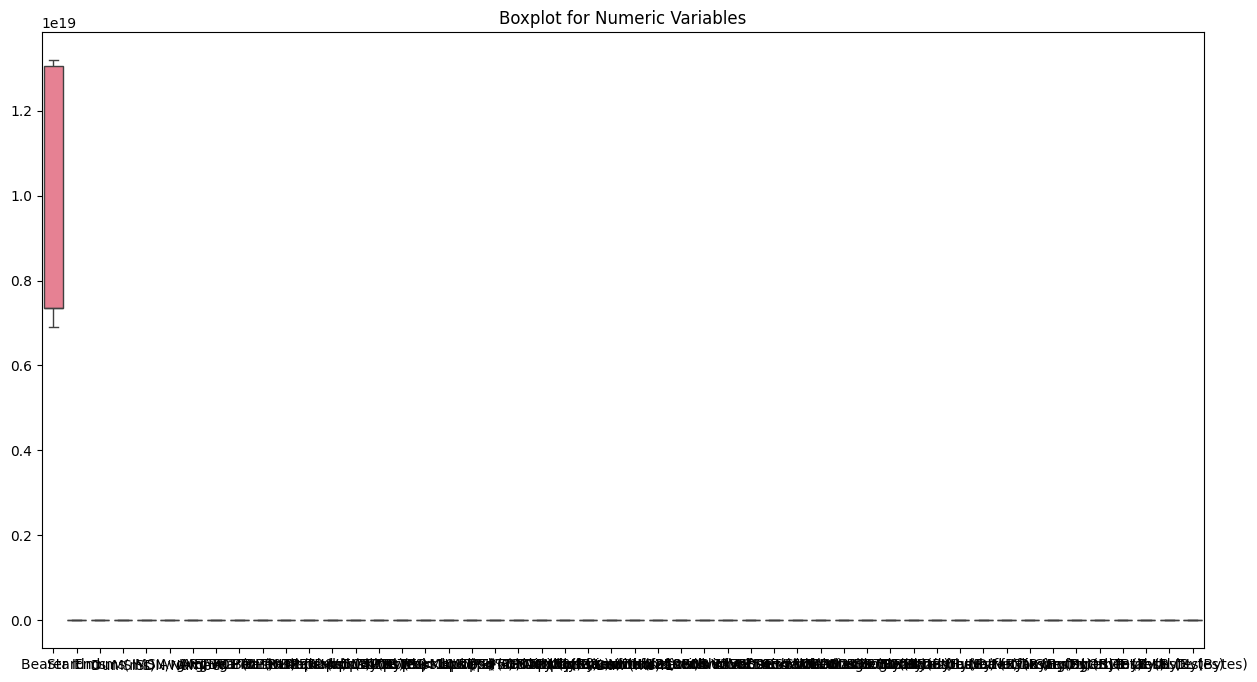

In [33]:
# Histogram for numeric variables
df[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms for Numeric Variables")
plt.savefig("histograms.png")

# Boxplot for numeric variables
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot for Numeric Variables")
plt.savefig("boxplot.png")


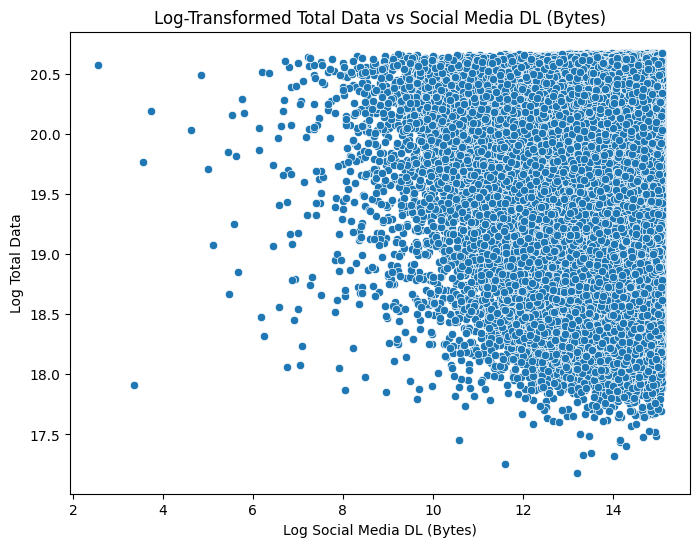

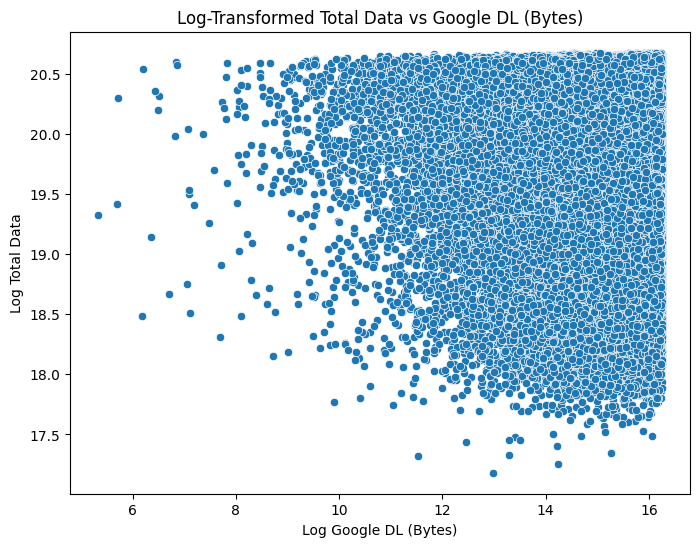

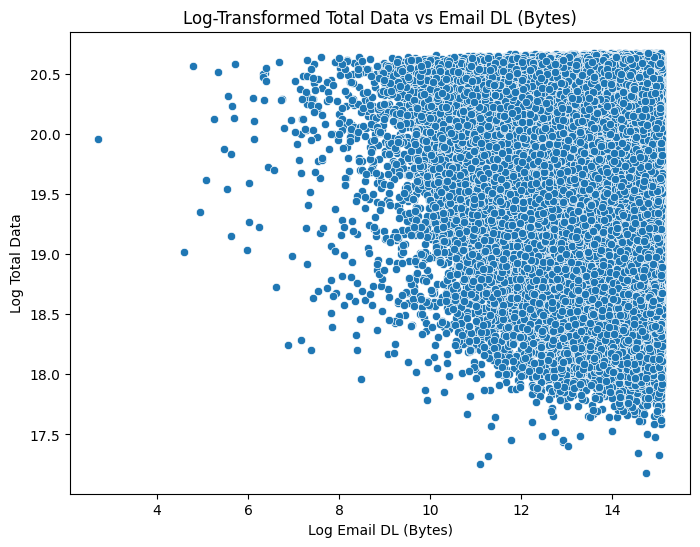

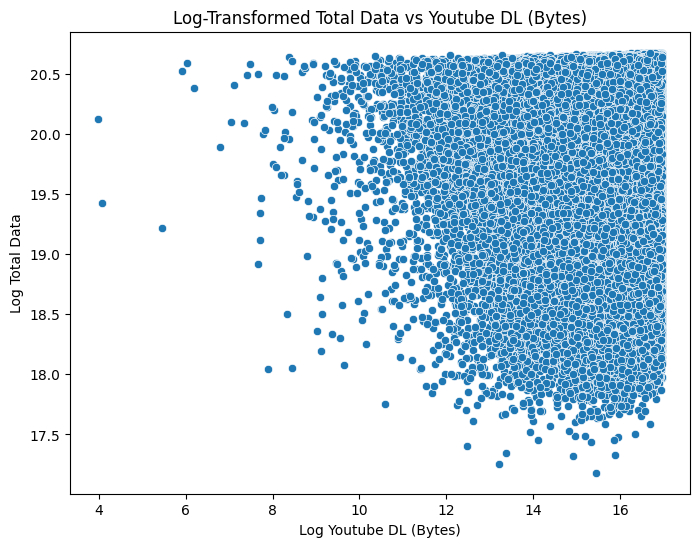

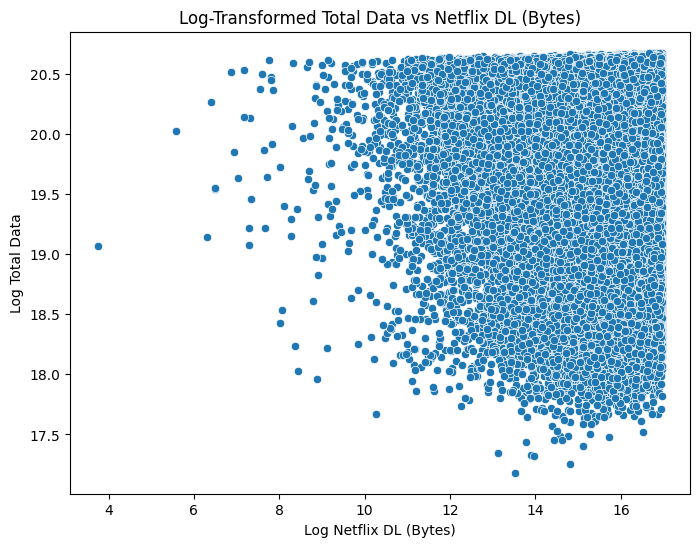

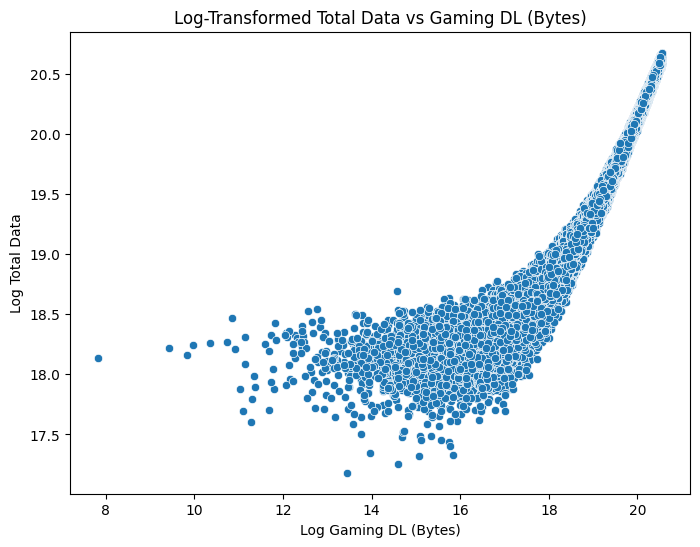

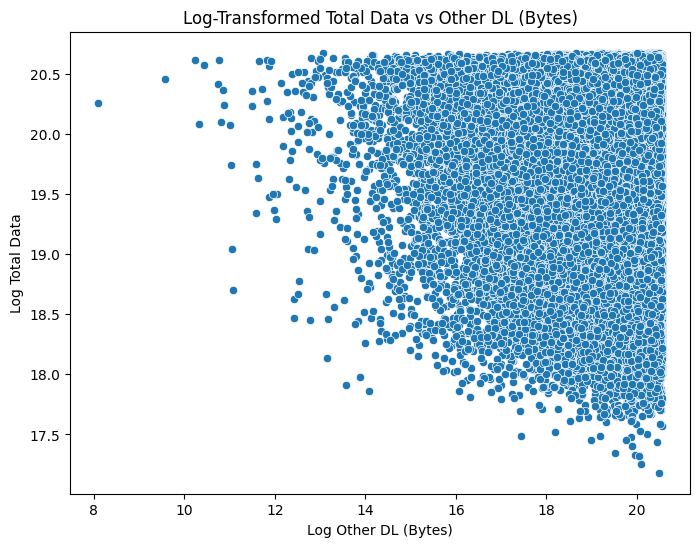

In [51]:
import numpy as np

# Scatterplot for total data vs applications (with log transform)
app_cols = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
            'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

for col in app_cols:
    plt.figure(figsize=(8, 6))
    
    # Log-transform the data (avoid log(0) by adding a small constant)
    log_x = np.log1p(df[col])  # log(1 + x) ensures no issues with zero values
    log_y = np.log1p(df['total_data'])
    
    # Scatterplot with log-transformed data
    sns.scatterplot(x=log_x, y=log_y)
    plt.title(f"Log-Transformed Total Data vs {col}")
    plt.xlabel(f"Log {col}")
    plt.ylabel("Log Total Data")
    
    # Save the plot
    plt.show()


Text(0, 0.5, 'Total Data')

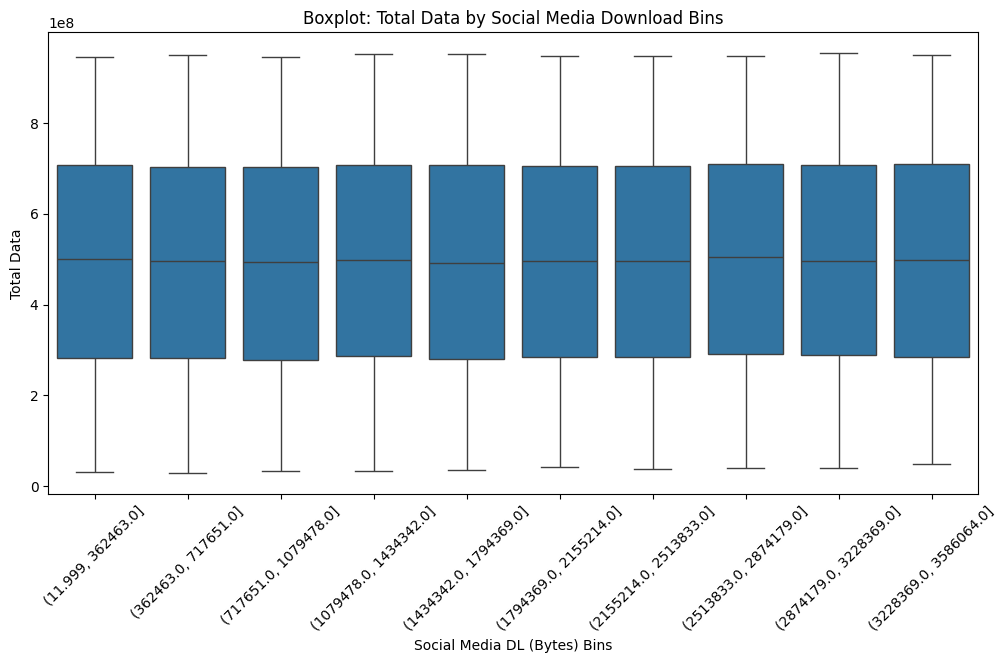

In [ ]:
import numpy as np

# Apply log transformation
df['log_social_media_dl'] = np.log1p(df['Social Media DL (Bytes)'])
df['log_total_data'] = np.log1p(df['total_data'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['log_social_media_dl'], y=df['log_total_data'], alpha=0.5)
plt.title("Scatter Plot (Log-Transformed): Total Data vs Social Media DL")
plt.xlabel("Log(Social Media DL Bytes)")
plt.ylabel("Log(Total Data)")
plt.savefig("log_scatter_social_media_dl.png")


Correlation Matrix:
                         Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.001954   
Google DL (Bytes)                      -0.001954           1.000000   
Email DL (Bytes)                        0.004745          -0.000039   
Youtube DL (Bytes)                     -0.001389           0.001760   
Netflix DL (Bytes)                     -0.001817           0.000548   
Gaming DL (Bytes)                       0.001018          -0.001421   
Other DL (Bytes)                        0.006126          -0.002557   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.004745           -0.001389   
Google DL (Bytes)               -0.000039            0.001760   
Email DL (Bytes)                 1.000000            0.001679   
Youtube DL (Bytes)               0.001679            1.000000   
Netflix DL (Bytes)               0.001351            0.001202   
Gaming DL (Bytes)    

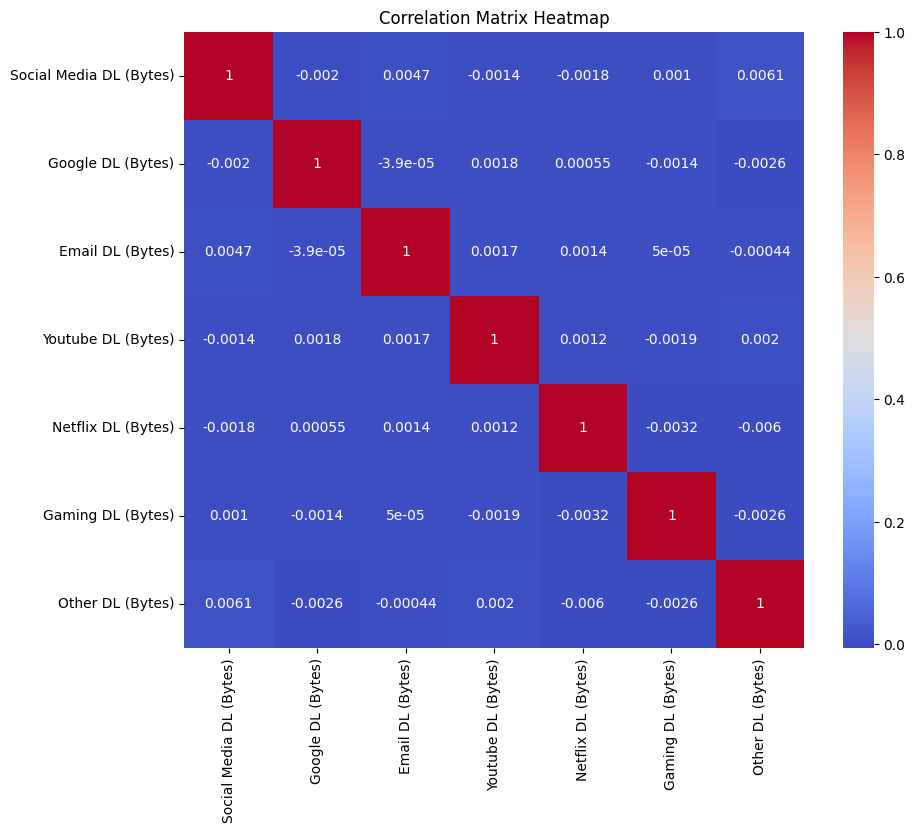

In [36]:
# Correlation matrix
corr_matrix = df[app_cols].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.savefig("correlation_heatmap.png")


Explained Variance Ratio: [0.14439453 0.14355429]


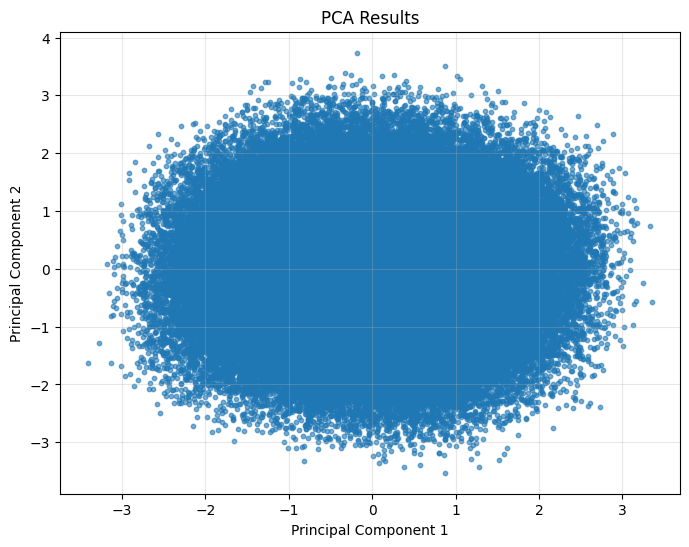

In [58]:
# Dimensionality Reduction (PCA)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[app_cols])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Variance explained by each component
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10, alpha=0.6)
plt.title("PCA Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)


In [ ]:
 # TASK 2